### Q9 TRON 幣流追蹤

參考: https://www.facebook.com/BlockTrend.today/posts/pfbid0cSTKnDohcKqKKkYykr7U3j6SLmkW9n9jxN42QhjMAUtuotrtb4dwtxr7k8NVQZxNl

>
>
>
> 4/9 更新：https://www.facebook.com/share/83soBt8hHrwETPom
> —
> 創意私房的金流高度仰賴加密貨幣，網站上也有公開的 TRON 收款地址。看起來創意私房收款者喜歡用 Trust Wallet，而且每隔一段時間就會換一組新地址收錢。以網址搭配網路時光機，就可以找到幾個創意私房使用過的收款錢包地址：
>
> - TA2G85LLXqtbcMwwZUKn4gDdQ9EkoHRp8V（目前使用中）
> - TJxBDgdAmD1NPy6ih4E6RBM4YQWZRACakZ
> - TPbRDKYYi5qT3Ayutw6NV31bvNX9zGivZx
> - TUQbf1PgWvxKethbrYLFY842UL6Z41RiKC
> 有了錢包地址，就可以回頭追查金流。把錢包地址丟進 OKLink 區塊鏈瀏覽器，可以看到最近一筆收款就在剛剛，從幣安交易所轉了 298 USDT 進來。再往前捲動，就會發現各家交易所名稱都會出現。
> 這些就是目前仍持續購買創意私房會員的轉帳。我只能說，用加密貨幣來買創意私房會員實在是很大膽。因為每筆鏈上轉帳都有流水號（txid），交易所手上則有用戶資料。只要把兩個東西兜起來，不就知道誰是買家了嗎？
> 但抓到買家沒什麼用，創意私房的錢流向何方才是檢警追查的重點。幣流分析公司肯定有更進階的工具，但一般人可以使用區塊勢曾經介紹過的 MetaSlueth 看個大概。會發現創意私房的金流滿狡猾，不是一大筆直接送到某個中心化交易所帳戶。而是分許多小筆送到不同帳戶變現或是做其他用途。
> 但無論金額大小，成為創意私房收款者肯定是有牽連，不然哪會無緣無故收到錢呢？如果仔細查，可能又會抓到一些賣帳號的人頭。通常鏈上金流追到中心化交易所就已經是終點了，接下來的資訊從鏈上看不到，只能仰賴執法單位跟交易所合作。畢竟法幣金流網路上查不到。
> 寫這篇想說的是，外行人看到創意私房使用加密貨幣收款，就說：「你看加密貨幣隱蔽性很高，是犯罪、洗錢的工具。」殊不知，鏈上金流比其他銀行金流更透明得多，連我這種鍵盤仔都可以花個幾分鐘看到金流流向。
> 缺的是一套將鏈上金流與傳統犯罪防治系統接在一起的跨境聯防機制。雖然大家都能看到金流跑去哪些交易所變現，但要跨境聯繫執法單位、請交易所配合，卻是更耗時費力的工作。只有檢警調的資訊流跑的比創意私房的金流更快，才有機會一口氣人贓俱獲。


## 查看付款者

因為已經有收款地址，我們可以先列出各個付款者，我們以地址 `TUQbf1PgWvxKethbrYLFY842UL6Z41RiKC` 為例

為了簡化問題，我把查詢時間範圍定在 '2024-01-01' -> '2024-05-05'

比較特別的是程式碼有額外定義兩個 TRON 的轉換函數，因為 TRON 習慣的地址格式並不是 HEX

```sql
DECLARE target_address_str STRING;
DECLARE target_address_hex STRING;
DECLARE target_date_start DATE DEFAULT DATE('2024-01-01');
DECLARE target_date_end DATE DEFAULT DATE('2024-05-05');
SET target_address_str = 'TUQbf1PgWvxKethbrYLFY842UL6Z41RiKC';

CREATE TEMP FUNCTION tronToHex(b58 STRING) RETURNS STRING
LANGUAGE js AS r"""
  const ALPHABET = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz';
  const ALPHABET_MAP = {};
  for(let i = 0; i < ALPHABET.length; i++) ALPHABET_MAP[ALPHABET[i]] = i;
  let bytes = [0];
  for(let i = 0; i < b58.length; i++) {
    const c = b58[i];
    for(let j = 0; j < bytes.length; j++) bytes[j] *= 58;
    bytes[0] += ALPHABET_MAP[c];
    let carry = 0;
    for(let j = 0; j < bytes.length; ++j) {
      bytes[j] += carry;
      carry = bytes[j] >> 8;
      bytes[j] &= 0xff;
    }
    while(carry) {
      bytes.push(carry & 0xff);
      carry >>= 8;
    }
  }
  for(let i = 0; b58[i] === '1' && i < b58.length - 1; i++) bytes.push(0);
  const decoded = bytes.reverse();
  const payload = decoded.slice(1, 21); // 取出中間的 20 Bytes Payload
  return '0x' + payload.map(b => b.toString(16).padStart(2, '0')).join('');
""";

CREATE TEMP FUNCTION hexToTron(address STRING) RETURNS STRING
LANGUAGE js OPTIONS (library=["gs://blockchain-etl-bigquery/ethers.js"]) AS r"""
    function encode58(buffer) {
        const ALPHABET = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz';
        const digits = [0];
        for (let i = 0; i < buffer.length; i++) {
            for (let j = 0; j < digits.length; j++) digits[j] <<= 8;
            digits[0] += buffer[i];
            let carry = 0;
            for (let j = 0; j < digits.length; ++j) {
                digits[j] += carry;
                carry = (digits[j] / 58) | 0;
                digits[j] %= 58;
            }
            while (carry) {
                digits.push(carry % 58);
                carry = (carry / 58) | 0;
            }
        }
        for (let i = 0; buffer[i] === 0 && i < buffer.length - 1; i++) digits.push(0);
        return digits.reverse().map((digit) => ALPHABET[digit]).join("");
    }
    function sha256(msgBytes) {
        const msgHex = ethers.utils.hexlify(msgBytes);
        const hashHex = ethers.utils.sha256(msgHex);
        return ethers.utils.arrayify(hashHex);
    }
    if(!address) return null;
    let addressBytes = ethers.utils.arrayify('0x' + address.replace(/^0x/, '41'));
    let checkSum = sha256(sha256(addressBytes)).slice(0, 4);
    return encode58(new Uint8Array([...addressBytes, ...checkSum]));
""";

SET target_address_hex = tronToHex(target_address_str);

SELECT
    block_timestamp,
    transaction_index,
    transaction_hash,
    hexToTron(from_address) AS from_address,
    hexToTron(to_address) AS to_address,
    value.bignumeric_value AS trx_amount,
    gas,
    gas_price.bignumeric_value
FROM `bigquery-public-data.goog_blockchain_tron_mainnet_us.transactions`
WHERE
  (from_address = target_address_hex OR to_address = target_address_hex)
  AND
  (DATE(block_timestamp) BETWEEN target_date_start AND target_date_end)
ORDER BY block_timestamp DESC
```

以下就是犯罪錢包在這段時間內的所有交易

[q9_data.json](./q9_data.json)


可以整理出表格，分別是

- 轉錢到犯罪地址
- 轉錢出犯罪地址


In [14]:
import pandas as pd

df = pd.read_json('q9_data.json')

df_Payer = df.query("to_address == 'TUQbf1PgWvxKethbrYLFY842UL6Z41RiKC'")
df_Payer = df_Payer.sort_values(by=['block_timestamp'], ascending=True)
# print(df_Payer.head())
# print all
# 印出這段時間轉入犯罪錢包的所有地址
for index, row in df_Payer.iterrows():
    print(row['block_timestamp'], row['from_address'], row['trx_amount'])

2024-01-03 16:28:54.000000 UTC TFEHfW4ZvTnpsfwG7ZtWTWsP14UgJoY5go 10000
2024-01-06 18:23:51.000000 UTC TGdtySXr8mZTNJXcAisHimRhUbgLj3t4C4 5
2024-01-06 18:23:57.000000 UTC TUqmPFHz6AGk2zLVtsd2DQvRWukqjzqqyo 1
2024-01-06 18:24:57.000000 UTC TSYvkKKKM9wpQV5qR9QEfANZioJyr4qZC4 1
2024-01-06 18:25:00.000000 UTC TPpFfFY1D5DNm1kHufJWAJEBt2v31rJ4C4 4
2024-01-07 04:45:09.000000 UTC TNXFt4cFxU2cxQds4bE31H6xkp64Y11Kkr 1
2024-01-08 06:23:09.000000 UTC TPpFfFY1D5DNm1kHufJWAJEBt2v31rJ4C4 1
2024-01-08 07:46:33.000000 UTC TDxQTBnBhiKBkBcEs3iivvsTCRuD5XYWZT 8880
2024-01-09 15:44:39.000000 UTC TPjoRuquNcjnbNu2rGdgUwVxV1sCyeHhhR 888888888
2024-01-09 16:01:03.000000 UTC TPeHkgWXnTtGWxN3UH7yvjKAWUmU7GzRqD 100000000
2024-01-09 17:06:36.000000 UTC TVLVktMPUNuaKGYXFwTdGwmUzKzHDxrQoP 888888888
2024-01-11 05:55:15.000000 UTC TTD7k3aK8vGdGjS9SHzRxnJTiPhzs5hVNv 1
2024-01-12 07:44:33.000000 UTC TAaN4G83A8y7MZcmgM7M2JtdRKt4kp1HHF 1
2024-01-13 16:21:12.000000 UTC TD6nvEwqMYSaJbqPinGnPeCBDjP3KK3QrL 8880
2024-01-14 08:

以上每個地址都可以嘗試追蹤，都是有付錢給創意私房的客戶

我舉例一個比較好追的地址 (TBHKmzrZ5SrfENJP5XF2TMwjZpT4HpYHQC)，在 OKLink 上可以看到他是 Bitkeep 的用戶

https://www.oklink.com/zh-hant/tron/address/TBHKmzrZ5SrfENJP5XF2TMwjZpT4HpYHQC

因為和真實環境有連接，所以這會是一個抓到人的突破口。

其實這裡的每一個帳戶都可以透過巢狀查詢來看看能不能抓到人，以下是針對創意私房錢包的演示

我會抓取時間內的所有交易做巢狀查詢，其中 0xca3f92F1874069622101A7E20C1744B68E9E550c 是 TBHKmzrZ5SrfENJP5XF2TMwjZpT4HpYHQC 地址的 hex 格式，便於在 big query 中使用

note: 深度不要太深，指數會爆炸

```sql
DECLARE target_date_start TIMESTAMP DEFAULT TIMESTAMP('2024-01-01 00:00:00 UTC');
DECLARE target_date_end TIMESTAMP DEFAULT TIMESTAMP('2024-06-01 00:00:00 UTC');

WITH RECURSIVE cash_flow_path AS (
    -- 【1】Base Case
    SELECT
        from_address,
        to_address,
        1 AS depth,
        [from_address, to_address] AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.transactions`
    WHERE
        -- ★ 記得替換為真實的 Tron 地址
        to_address = LOWER('0xca3f92f1874069622101a7e20c1744b68e9e550c')
        AND (block_timestamp >= target_date_start AND block_timestamp < target_date_end)

    UNION ALL

    -- 【2】Recursive Case
    SELECT
        t.from_address,
        t.to_address,
        c.depth + 1 AS depth,
        ARRAY_CONCAT([t.from_address], c.path_array) AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.transactions` AS t
    INNER JOIN
        cash_flow_path AS c
    ON
        t.to_address = c.from_address
    WHERE
        c.depth < 3
        AND (t.block_timestamp >= target_date_start AND t.block_timestamp < target_date_end)
        AND NOT EXISTS (
            SELECT 1 FROM UNNEST(c.path_array) AS visited_node
            WHERE visited_node = t.from_address
        )
)

SELECT
    depth,
    from_address,
    to_address,
    ARRAY_TO_STRING(path_array, ' -> ') AS full_path
FROM
    cash_flow_path
ORDER BY
    depth ASC;
```

另外，如果可以取得已知身分的地址的表格，融合巢狀搜索，可以較為自動化的完成金流分析

補充 big query 帳單查詢法

```sql
SELECT
  EXTRACT(YEAR FROM creation_time) AS query_year,
  EXTRACT(MONTH FROM creation_time) AS query_month,
  -- 將 Bytes 轉換為 TB
  ROUND(SUM(total_bytes_billed) / POW(1024, 4), 4) AS total_tb_billed,

  -- 粗略估算花費 (假設每 TB $6.25 USD，未扣除 1TB 免費額度)
  ROUND((SUM(total_bytes_billed) / POW(1024, 4)) * 6.25, 2) AS estimated_cost_usd,

  -- 統計本月跑了幾次查詢
  COUNT(*) AS total_query_count
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS -- 這裡的 region 必須對應你專案執行查詢的區域
WHERE
  -- 限制時間為本月第一天起算
  creation_time >= TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), MONTH)
  AND job_type = 'QUERY'
  AND state = 'DONE'
GROUP BY 1, 2
ORDER BY 1, 2;
```

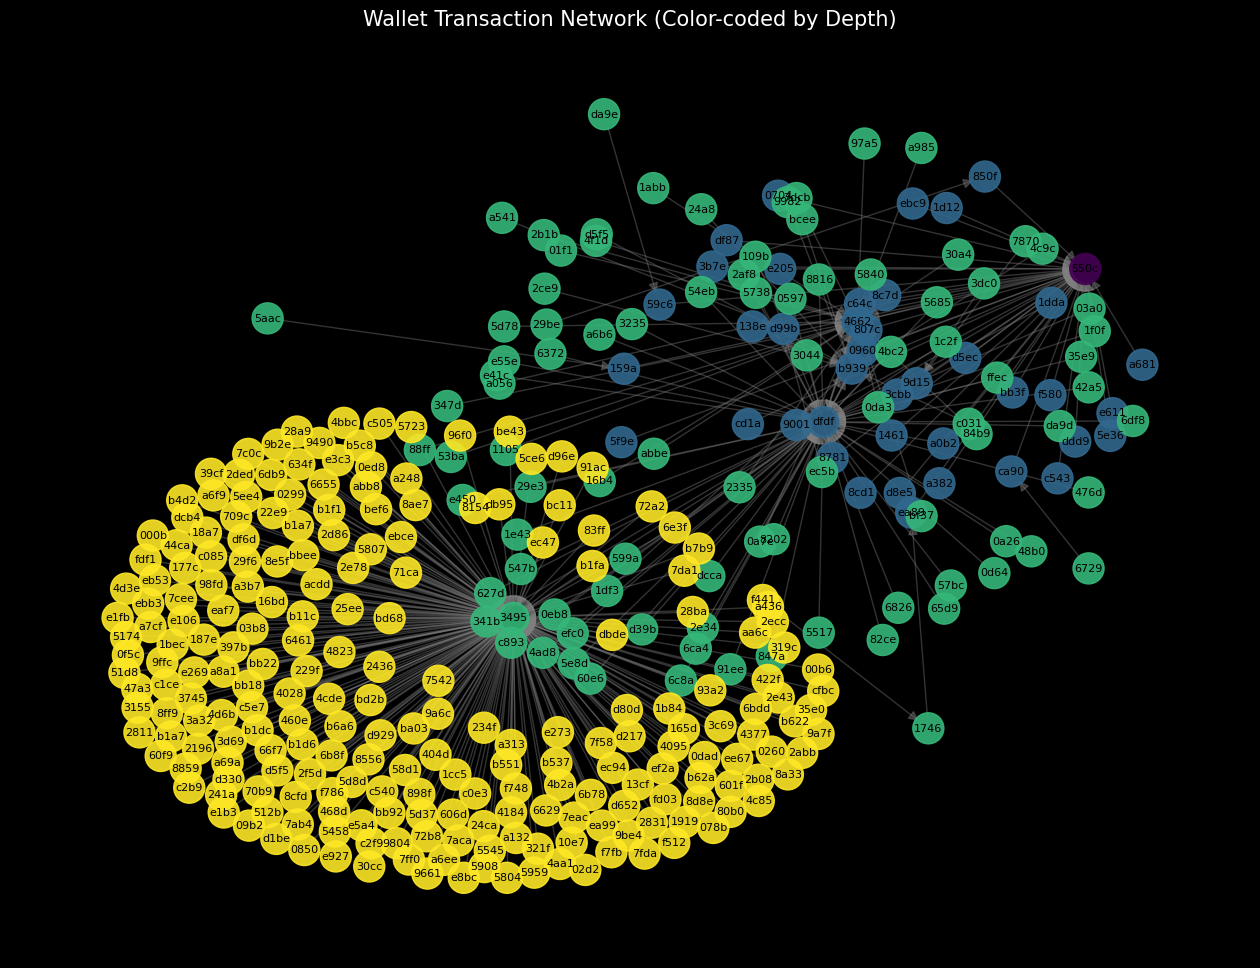

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_json('q9_data2.json')
# df = df.query("depth == 2")

G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['from_address'], row['to_address'], depth=int(row['depth']))

plt.figure(figsize=(16, 12))

node_depths = {}
for _, row in df.iterrows():
    f, t, d = row['from_address'], row['to_address'], int(row['depth'])
    node_depths[f] = min(node_depths.get(f, 99), d)
    node_depths[t] = min(node_depths.get(t, 99), d - 1 if d > 0 else 0)

colors = [node_depths.get(node, 0) for node in G.nodes()]

labels = {node: f"{node[-4:]}" for node in G.nodes()}

pos = nx.spring_layout(G, k=0.15, iterations=30)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, cmap=plt.cm.viridis, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.4, edge_color='gray', arrows=True, arrowsize=15)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family='sans-serif')

plt.title("Wallet Transaction Network (Color-coded by Depth)", fontsize=15)
plt.axis('off')

plt.show()

基本上，上圖就是把錢轉入創意私房的金流圖

如果圖片太複雜，可以採用 DFS 或 BFS 的方式分析，目標是找到已知身分的地址

例如在深度 2 的 0x0E6544B7A641e3C9DAEf401568CA0A68Ff77D99B 就是上面提到的地址 TBHKmzrZ5SrfENJP5XF2TMwjZpT4HpYHQC

在 OKLINK 上可以查到是 Bitkeep 用戶

note: 地址格式轉換可以自己寫程式轉，也可以用 https://www.tron-converter.com/


接著嘗試查詢轉出創意私房地址的金流

```sql
DECLARE target_date_start TIMESTAMP DEFAULT TIMESTAMP('2024-01-01 00:00:00 UTC');
DECLARE target_date_end TIMESTAMP DEFAULT TIMESTAMP('2024-06-1 00:00:00 UTC');

WITH RECURSIVE cash_flow_path AS (
    -- 【1】Base Case
    SELECT
        from_address,
        to_address,
        1 AS depth,
        [from_address, to_address] AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.transactions`
    WHERE
        -- ★ 記得替換為真實的 Tron 地址
        from_address = LOWER('0xca3f92f1874069622101a7e20c1744b68e9e550c')
        AND (block_timestamp >= target_date_start AND block_timestamp < target_date_end)

    UNION ALL

    -- 【2】Recursive Case
    SELECT
        t.from_address,
        t.to_address,
        c.depth + 1 AS depth,
        ARRAY_CONCAT(c.path_array, [t.to_address]) AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.transactions` AS t
    INNER JOIN
        cash_flow_path AS c
    ON
        t.from_address = c.to_address
    WHERE
        c.depth < 3
        AND (t.block_timestamp >= target_date_start AND t.block_timestamp < target_date_end)
        AND NOT EXISTS (
            SELECT 1 FROM UNNEST(c.path_array) AS visited_node
            WHERE visited_node = t.to_address
        )
)

SELECT
    depth,
    from_address,
    to_address,
    ARRAY_TO_STRING(path_array, ' -> ') AS full_path
FROM
    cash_flow_path
ORDER BY
    depth ASC;
```

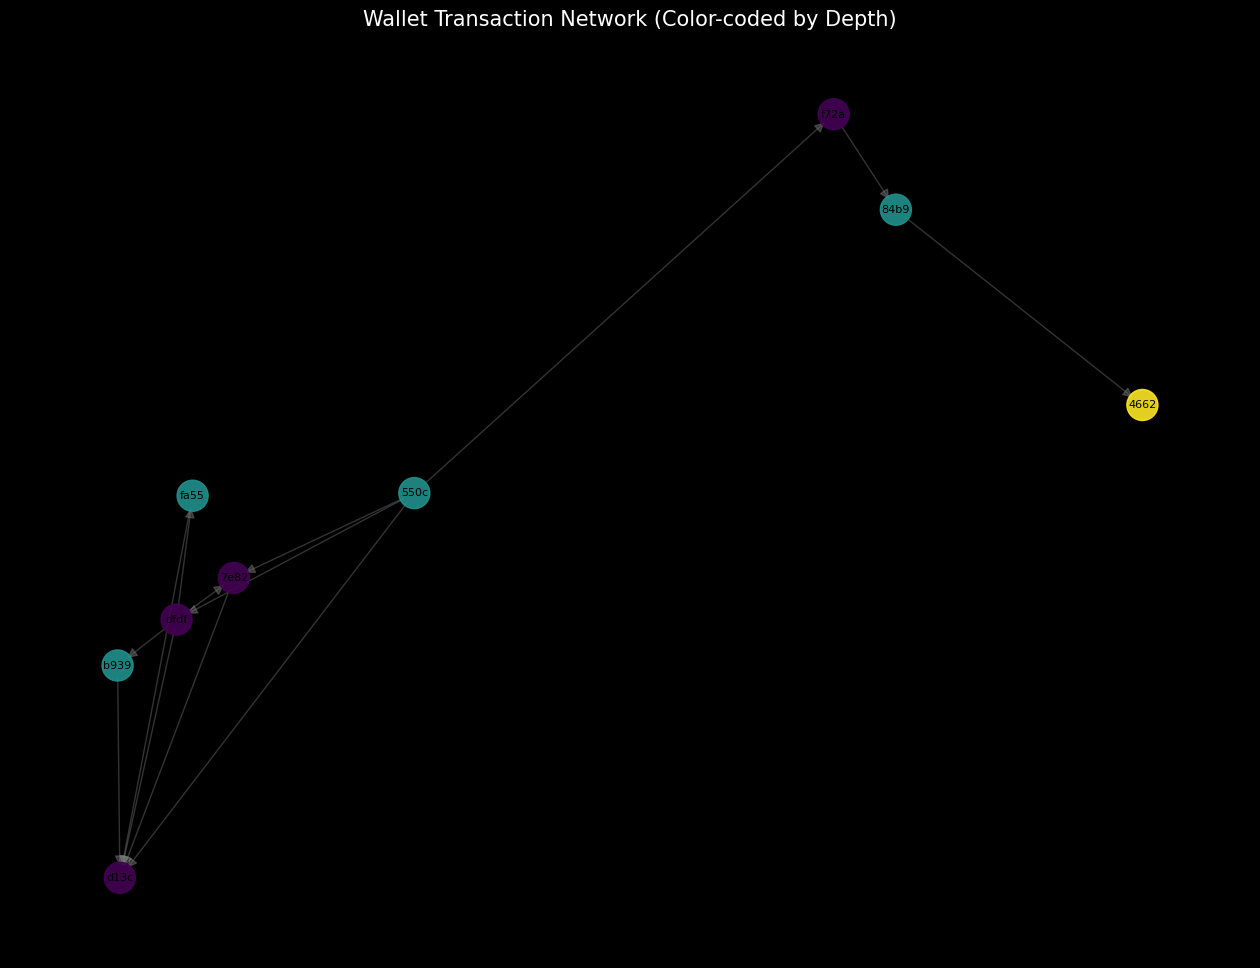

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_json('q9_data3.json')
# df = df.query("depth == 2")

G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['from_address'], row['to_address'], depth=int(row['depth']))

plt.figure(figsize=(16, 12))

node_depths = {}
for _, row in df.iterrows():
    f, t, d = row['from_address'], row['to_address'], int(row['depth'])
    node_depths[f] = min(node_depths.get(f, 99), d)
    node_depths[t] = min(node_depths.get(t, 99), d - 1 if d > 0 else 0)

colors = [node_depths.get(node, 0) for node in G.nodes()]

labels = {node: f"{node[-4:]}" for node in G.nodes()}

pos = nx.spring_layout(G, k=0.15, iterations=30)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, cmap=plt.cm.viridis, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.4, edge_color='gray', arrows=True, arrowsize=15)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family='sans-serif')

plt.title("Wallet Transaction Network (Color-coded by Depth)", fontsize=15)
plt.axis('off')

plt.show()

仔細觀察上圖可以發現，金流多數轉入 0xa614f803b6fd780986a42c78ec9c7f77e6ded13c

0xa614f803b6fd780986a42c78ec9c7f77e6ded13c 的 TRON 格式為 TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t

在 OKLINK 上可以得知是 Token: Tether USD 合約

至此可以得知，該帳戶主要是透過 USD Tether 幣在轉移虛擬貨幣

所以接下來要回過頭來，用 USDT 的流動來查詢

note: 其實，按照新聞，有人用 USDT 付款，一開始就可以直接查 USDC 金流了，不用繞一圈


## USDT 金流

因為 USDT 是穩定幣，所以主要就是重複上面流程，只不過把

- from_address 改成該合約 transfer event 的 from 參數
- to_address 改成該合約 transfer event 的 to 參數

細節直接觀察合約內的交易數據即可推測: https://www.oklink.com/zh-hant/tron/address/TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t

接下來改成追蹤符合條件的 event

以下程式碼會抓出轉 USDT 給目標地址的路徑
```sql
DECLARE target_date_start TIMESTAMP DEFAULT TIMESTAMP('2024-01-01 00:00:00 UTC');
DECLARE target_date_end TIMESTAMP DEFAULT TIMESTAMP('2024-06-01 00:00:00 UTC');

WITH RECURSIVE cash_flow_path AS (
    -- 【1】Base Case
    SELECT
        topics[SAFE_OFFSET(1)] as from_address,
        topics[SAFE_OFFSET(2)] as to_address,
        1 AS depth,
        [topics[SAFE_OFFSET(1)], topics[SAFE_OFFSET(2)]] AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.logs`
    WHERE
        topics[SAFE_OFFSET(0)] = LOWER('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef')
        AND address = LOWER('0xa614f803b6fd780986a42c78ec9c7f77e6ded13c')
        AND topics[SAFE_OFFSET(2)] = LOWER('0x000000000000000000000000ca3f92f1874069622101a7e20c1744b68e9e550c')
        AND (block_timestamp >= target_date_start AND block_timestamp < target_date_end)

    UNION ALL

    -- 【2】Recursive Case
    SELECT
        t.topics[SAFE_OFFSET(1)] as from_address,
        t.topics[SAFE_OFFSET(2)] as to_address,
        c.depth + 1 AS depth,
        ARRAY_CONCAT([t.topics[SAFE_OFFSET(1)]], c.path_array) AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.logs` AS t
    INNER JOIN
        cash_flow_path AS c
    ON
        t.topics[SAFE_OFFSET(2)] = c.from_address
    WHERE
        c.depth < 2
        AND topics[SAFE_OFFSET(0)] = LOWER('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef')
        AND address = LOWER('0xa614f803b6fd780986a42c78ec9c7f77e6ded13c')
        AND (t.block_timestamp >= target_date_start AND t.block_timestamp < target_date_end)
        AND NOT EXISTS (
            SELECT 1 FROM UNNEST(c.path_array) AS visited_node
            WHERE visited_node = t.topics[SAFE_OFFSET(1)]
        )
)

SELECT
    depth,
    from_address,
    to_address,
    ARRAY_TO_STRING(path_array, ' -> ') AS full_path
FROM
    cash_flow_path
ORDER BY
    depth ASC;
```
由於資料量過大，我簡單複製一段演示
```json lines
{
  "depth": "1",
  "from_address": "0x0000000000000000000000000b48984414cc0c6a8e599fb6e3bc11e599de2e24",
  "to_address": "0x000000000000000000000000ca3f92f1874069622101a7e20c1744b68e9e550c",
  "full_path": "0x0000000000000000000000000b48984414cc0c6a8e599fb6e3bc11e599de2e24 -\u003e 0x000000000000000000000000ca3f92f1874069622101a7e20c1744b68e9e550c"
}
{
  "depth": "1",
  "from_address": "0x0000000000000000000000000b48984414cc0c6a8e599fb6e3bc11e599de2e24",
  "to_address": "0x000000000000000000000000ca3f92f1874069622101a7e20c1744b68e9e550c",
  "full_path": "0x0000000000000000000000000b48984414cc0c6a8e599fb6e3bc11e599de2e24 -\u003e 0x000000000000000000000000ca3f92f1874069622101a7e20c1744b68e9e550c"
}
```
直接抓到地址 "0x0b48984414cc0c6a8e599fb6e3bc11e599de2e24" 轉給目標地址，且該地址為 TAzsQ9Gx8eqFNFSKbeXrbi45CuVPHzA8wr 是幣安錢包，可以直接鎖定真人，因為有 KYC 認證


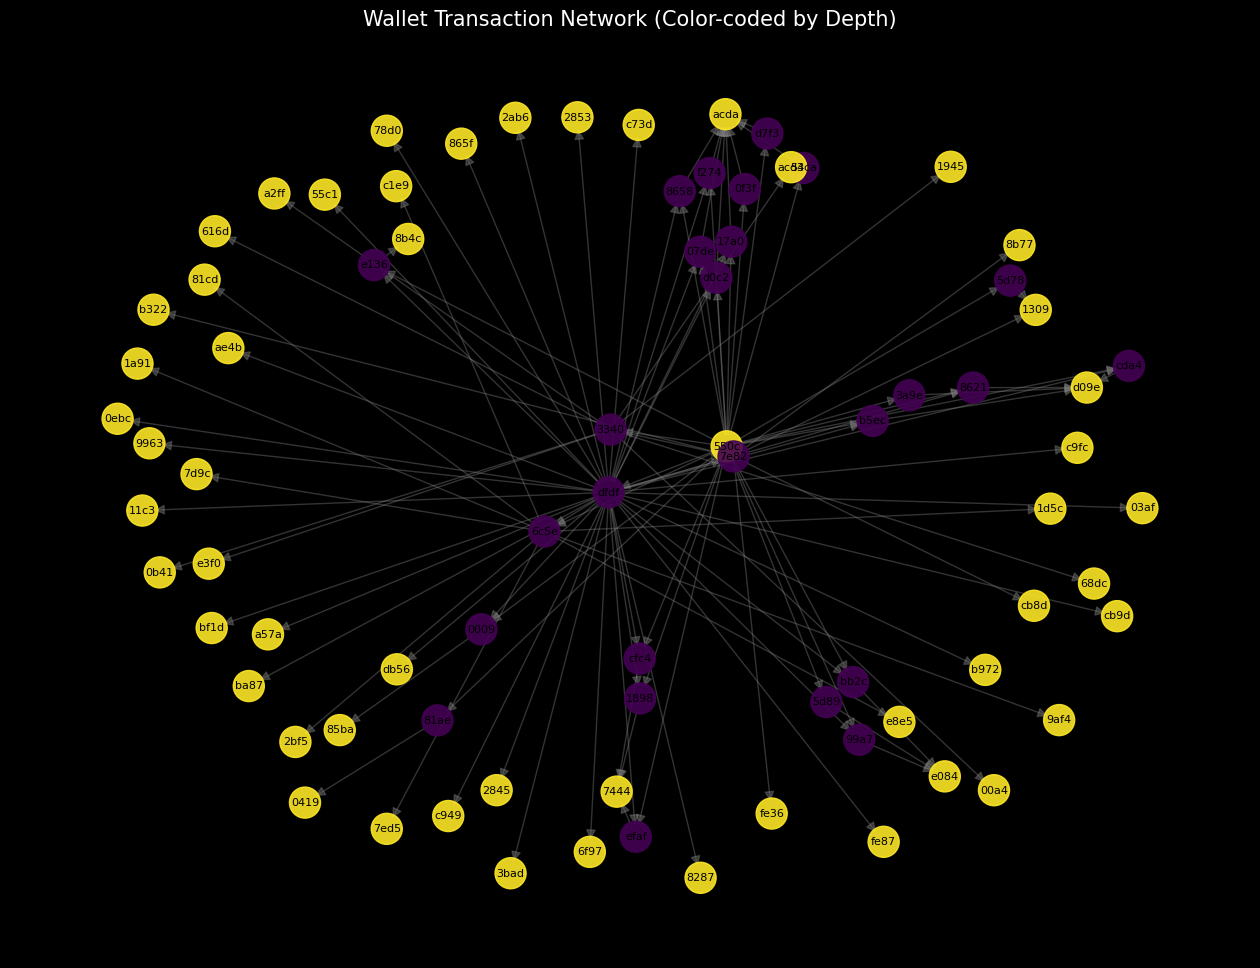

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_json('q9_data4.json')
# df = df.query("depth == 2")

G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['from_address'], row['to_address'], depth=int(row['depth']))

plt.figure(figsize=(16, 12))

node_depths = {}
for _, row in df.iterrows():
    f, t, d = row['from_address'], row['to_address'], int(row['depth'])
    node_depths[f] = min(node_depths.get(f, 99), d)
    node_depths[t] = min(node_depths.get(t, 99), d - 1 if d > 0 else 0)

colors = [node_depths.get(node, 0) for node in G.nodes()]

labels = {node: f"{node[-4:]}" for node in G.nodes()}

pos = nx.spring_layout(G, k=0.15, iterations=30)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, cmap=plt.cm.viridis, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.4, edge_color='gray', arrows=True, arrowsize=15)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family='sans-serif')

plt.title("Wallet Transaction Network (Color-coded by Depth)", fontsize=15)
plt.axis('off')

plt.show()


以下程式碼會抓出從目標地址轉出 USDT 的金流
```sql
DECLARE target_date_start TIMESTAMP DEFAULT TIMESTAMP('2024-01-01 00:00:00 UTC');
DECLARE target_date_end TIMESTAMP DEFAULT TIMESTAMP('2024-06-01 00:00:00 UTC');

WITH RECURSIVE cash_flow_path AS (
    -- 【1】Base Case
    SELECT
        topics[SAFE_OFFSET(1)] as from_address,
        topics[SAFE_OFFSET(2)] as to_address,
        1 AS depth,
        [topics[SAFE_OFFSET(1)], topics[SAFE_OFFSET(2)]] AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.logs`
    WHERE
        topics[SAFE_OFFSET(0)] = LOWER('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef')
        AND address = LOWER('0xa614f803b6fd780986a42c78ec9c7f77e6ded13c')
        AND topics[SAFE_OFFSET(1)] = LOWER('0x000000000000000000000000ca3f92f1874069622101a7e20c1744b68e9e550c')
        AND (block_timestamp >= target_date_start AND block_timestamp < target_date_end)

    UNION ALL

    -- 【2】Recursive Case
    SELECT
        t.topics[SAFE_OFFSET(1)] as from_address,
        t.topics[SAFE_OFFSET(2)] as to_address,
        c.depth + 1 AS depth,
        ARRAY_CONCAT(c.path_array, [t.topics[SAFE_OFFSET(2)]]) AS path_array
    FROM
        `bigquery-public-data.goog_blockchain_tron_mainnet_us.logs` AS t
    INNER JOIN
        cash_flow_path AS c
    ON
        t.topics[SAFE_OFFSET(1)] = c.to_address
    WHERE
        c.depth < 2
        AND topics[SAFE_OFFSET(0)] = LOWER('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef')
        AND address = LOWER('0xa614f803b6fd780986a42c78ec9c7f77e6ded13c')
        AND (t.block_timestamp >= target_date_start AND t.block_timestamp < target_date_end)
        AND NOT EXISTS (
            SELECT 1 FROM UNNEST(c.path_array) AS visited_node
            WHERE visited_node = t.topics[SAFE_OFFSET(2)]
        )
)

SELECT
    depth,
    from_address,
    to_address,
    ARRAY_TO_STRING(path_array, ' -> ') AS full_path
FROM
    cash_flow_path
ORDER BY
    depth ASC;

```

此時隨便找一個末端端點，例如

- 0x2a68baf67f1c497d9a4a609276a90dcd6ea77444
- 即為: TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf

在 OKLINK 上就抓到他是幣安帳戶了

ref: https://www.oklink.com/zh-hant/tron/address/TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf

以上，整個幣流追蹤就結束了